In [1]:
from math import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
######################  Importation des valeurs ###################### 
file1="/users/2024/ds2/122003362/Téléchargements/KinectDataGreenhouse/Box1_Temoin.csv"
df1 = pd.read_csv(file1)

file2="/users/2024/ds2/122003362/Téléchargements/KinectDataGreenhouse/Box2_Stress_hydrique.csv"
df2=pd.read_csv(file2)

file3="/users/2024/ds2/122003362/Téléchargements/KinectDataGreenhouse/Box3_stress_salin.csv"
df3=pd.read_csv(file3)

file4="/users/2024/ds2/122003362/Téléchargements/KinectDataGreenhouse/Box4_Temoin.csv"
df4=pd.read_csv(file4)

In [5]:
###################### Calcul de nombre de jour ###################### 

# On a mesuré la distance à la caméra de la plante toutes les 15min
# Ici on a une valeur pour T_échantillonage = 15min mais T = 1 jour = 96*15min
# D'où 1 jour = 96 mesures

T_e = 15            # T_échantillonage en min

T = 60/T_e * 24      # Nombre de mesure pour 1 jour

n=int(len(df1)/T)    
print("le nombre de jour <complet> : ", n)

T_dernier_jour=int(len(df1)-T*n)
print("le nombre de mesures sur le jour <incomplet:>", T_dernier_jour)

le nombre de jour <complet> :  12
le nombre de mesures sur le jour <incomplet:> 87


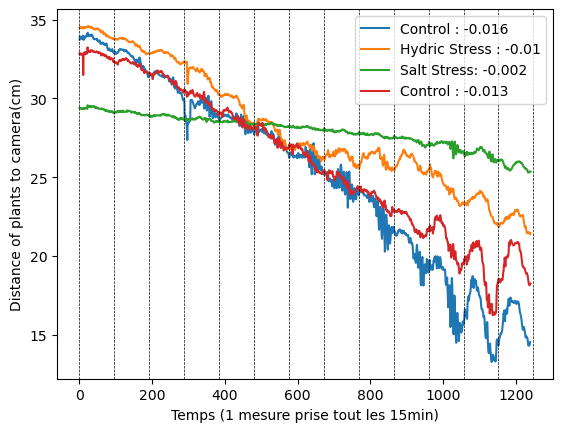

In [6]:
###################### Les graphes ###################### 

plt.plot(df1['X'],df1['Y'], label='Control : -0.016')
plt.plot(df2['X'],df2['Y'], label='Hydric Stress : -0.01')
plt.plot(df3['X'],df3['Y'], label='Salt Stress: -0.002')
plt.plot(df4['X'],df4['Y'], label='Control : -0.013')
plt.legend()
plt.xlabel('Temps (1 mesure prise tout les 15min)')
plt.ylabel('Distance of plants to camera(cm)')
for k in range(14):
    plt.axvline(T*k,color='black',linestyle='--',linewidth=0.5)

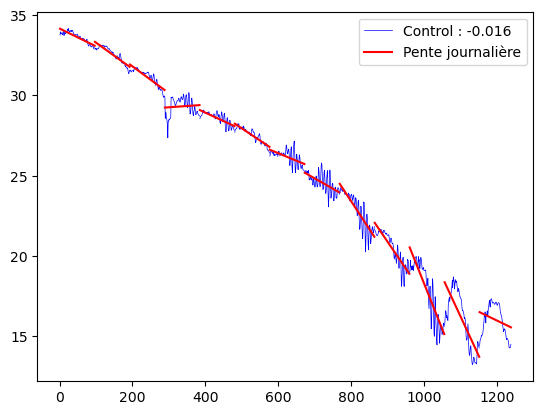

In [7]:
###################### Calcule de la pente journalière de la courbe 'Control' ######################

# On va faire une boucle sur chaque 96 valeurs
# Attention on a 1239 valeur or 96*12 = 1152 donc il faudra rajouter le dernier jour (qui est plus court)

from scipy import stats

def pente(x,y,n=12,T=96):
    pentes=[]
    for k in list(np.linspace(T,n*T,n)):
        
        #on fait un régression linéaire pour trouver la pente journalière :
        slope, intercept, r_value, p_value, std_err = stats.linregress(x[int(k)-T:int(k)],y[int(k)-T:int(k)])
        pentes.append(slope)
        plt.plot(x[int(k)-T:int(k)],y[int(k)-T:int(k)],color='blue',linewidth=0.5)
        plt.plot(x[int(k)-T:int(k)],slope*x[int(k)-T:int(k)]+intercept,color='red')
        
    # On rajoute la pente du dernier jour à la listes des pentes :
    slope, intercept, r_value, p_value, std_err = stats.linregress(x[n*T:],y[n*T:])
    plt.plot(x[n*T:],y[n*T:],color='blue',linewidth=0.5, label='Control : -0.016')
    plt.plot(x[n*T:],slope*x[n*T:]+intercept,color='red', label='Pente journalière')
    plt.legend()
    pentes.append(slope)
    
    return(pentes)

liste_pentes=pente(df1['X'],df1['Y'])
#print(liste_pentes)

In [ ]:
# Calcule des c1 de la courbe 'Control'

def pente_et_c1(x,y,n=12,T=96):
    pentes=[]
    les_c1=[]
    
    for k in list(np.linspace(96,12*96,12)):
        
        #Calcul de la pente journalière :
        slope, intercept, r_value, p_value, std_err = stats.linregress(x[int(k)-96:int(k)],y[int(k)-96:int(k)])
        pentes.append(slope)
        
        #Calcul de c1 pour chaque jour :
        Y=y[int(k)-96:int(k)]-(x[int(k)-96:int(k)]*slope+intercept) # calcul de y(t,k) pour la k-ième journée
        A=[np.cos(2*np.pi*t/T) for t in range(int(k)-96,int(k))]
        B=[np.sin(2*np.pi*t/T) for t in range(int(k)-96,int(k))]
        a1=(2/T)*sum(Y*A)
        b1=(2/T)*sum(Y*B)
        c1=np.sqrt(a1**2+b1**2)
        les_c1.append(c1)
        
    #Calcul de la pente du dernier jour
    slope, intercept, r_value, p_value, std_err = stats.linregress(x[12*96:],y[12*96:])
    pentes.append(slope)
    
    #Calcul de c1 pour le dernier jour :
    Y=y[12*96:]-(x[12*96:]*slope+intercept) # calcul de y(t,n) pour le dernier jour
    A=[np.cos(2*np.pi*t/87) for t in range(12*96,12*96+87)]
    B=[np.sin(2*np.pi*t/87) for t in range(12*96,12*96+87)]
    a1=(2/87)*sum(Y*A)
    b1=(2/87)*sum(Y*B)
    c1=np.sqrt(a1**2+b1**2)
    les_c1.append(c1)
    
    return(pentes,les_c1)

liste_pentes,les_c1=pente_et_c1(df1['X'],df1['Y'])
#print(liste_pentes)
#print(les_c1)
plt.scatter(np.linspace(1,13,13),les_c1)

In [ ]:
# Calcule du HDR : Harmonic Distortion Rate

def pente_et_c1_et_HDR(x,y):
    T=96
    pentes=[]
    les_c1=[]
    les_HDR=[]
    for k in list(np.linspace(96,12*96,12)):
        
        #Calcul de la pente journalière :
        slope, intercept, r_value, p_value, std_err = stats.linregress(x[int(k)-96:int(k)],y[int(k)-96:int(k)])
        pentes.append(slope)
        
        #Calcul de c1 pour chaque jour :
        Y=y[int(k)-96:int(k)]-(x[int(k)-96:int(k)]*slope+intercept) # calcul de y(t,k) pour la k-ième journée
        A=[np.cos(2*np.pi*t/T) for t in range(int(k)-96,int(k))]
        B=[np.sin(2*np.pi*t/T) for t in range(int(k)-96,int(k))]
        a1=(2/T)*sum(Y*A)
        b1=(2/T)*sum(Y*B)
        c1=np.sqrt(a1**2+b1**2)
        les_c1.append(c1)
        
        #Calcul du HDR pour chaque jour :
        E=(1/T)*sum(Y*Y)
        HDR = np.sqrt((E - 0.5*c1**2)/(0.5*c1**2))
        les_HDR.append(HDR)
        
    #Calcul de la pente du dernier jour
    slope, intercept, r_value, p_value, std_err = stats.linregress(x[12*96:],y[12*96:])
    pentes.append(slope)
    
    #Calcul de c1 pour le dernier jour :
    Y=y[12*96:]-(x[12*96:]*slope+intercept) # calcul de y(t,n) pour le dernier jour
    A=[np.cos(2*np.pi*t/87) for t in range(12*96,12*96+87)]
    B=[np.sin(2*np.pi*t/87) for t in range(12*96,12*96+87)]
    a1=(2/87)*sum(Y*A)
    b1=(2/87)*sum(Y*B)
    c1=np.sqrt(a1**2+b1**2)
    les_c1.append(c1)
    
    #Calcul de HDR du dernier jour
    E=(1/87)*sum(Y*Y)
    HDR = np.sqrt((E - 0.5*c1**2)/(0.5*c1**2))
    les_HDR.append(HDR)
    
    return(pentes,les_c1,les_HDR)

liste_pentes,les_c1,les_HDR=pente_et_c1_et_HDR(df1['X'],df1['Y'])
print(les_HDR)
plt.scatter(np.linspace(1,13,13),les_HDR)